In [2]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
config = {
  "save_plots": False,
}

In [4]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset

# download dataset using ogb pytorch geometric loader.
dataset = PygNodePropPredDataset(name="ogbn-arxiv")

data = dataset[0] # pyg graph object

print(data)

Data(edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


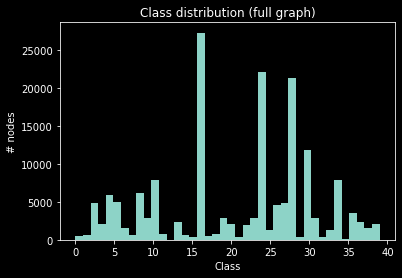

In [5]:
import matplotlib.pyplot as plt

plt.title("Class distribution (full graph)")
plt.hist(data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.savefig("cora-class-dist.png")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: True
graph has # weakly connected components: 1
graph has # isolated nodes: 0


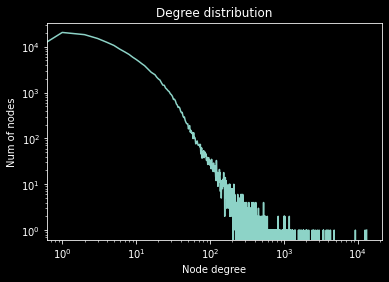

In [11]:
from lib import util

util.describe_graph(data, save_fig=config["save_plots"], log_scale=True)

## Split data set

In [7]:
from lib.data import split_dataset, split

graphs = []
#node_years = torch.unique(data.node_year[:,0])
#node_years = node_years[10:] # first years are too few nodes

node_years = [2000,2005,2010,2015,2020]

calibration_frac = 0.2
for year in node_years:
  print("year: {}".format(year))
  indices = torch.nonzero(torch.where(data.node_year[:,0] <= year, 1, 0))[:,0].tolist()

  year_data = split(data, indices)

  # TODO: Retrieve test_indices only from current year
  train_data, calibration_indices, test_indices = split_dataset(year_data, test_frac=0.2, calibration_frac=calibration_frac)
  graphs.append({
    "year": year,
    "data": year_data,
    "train_data": train_data,
    "calibration_indices": calibration_indices,
    "test_indices": test_indices,
  })

  calibration_frac = 0 # only get calibration indices for first train data


year: 2000
year: 2005
year: 2010
year: 2015
year: 2020


# GraphSAGE model

In [18]:
from lib.graphsage import GraphSAGE
from lib.evaluation import get_multiclass_classification_performance

from copy import deepcopy

from torch_geometric import graphgym

args = {
    "num_layers": 2,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 30,
    "batch_size": 10000,
    "num_neighbors": [10,3],
}

model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"], args["num_neighbors"])

# load checkpoint
# model.load_state_dict(torch.load("model_2000.pt")["model_state_dict"])

# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

loss_fn = torch.nn.NLLLoss()

models = {}
for graph in graphs:
    print("training: {}".format(graph["year"]))
    for epoch in range(1, 1 + args["epochs"]):
        loss = model.train_model(graph["train_data"], optimizer, loss_fn, args["batch_size"])
    models[graph["year"]] = deepcopy(model)
    
    # save checkpoint
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }, "model_{}.pt".format(graph["year"]))

training: 2000
training: 2005
training: 2010
training: 2015


In [ ]:
# evaluate
for graph in graphs:
  year = graph["year"]
  data = graph["data"]
  test_indices = graph["test_indices"]
  model = models[year]
  
  model.eval()

  y_hat = model.predict(data)
  y_hat = y_hat[test_indices]
  y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

  y_true = data.y[test_indices].reshape(-1)

  acc, balanced_acc = get_multiclass_classification_performance(y_hat, y_true)

  print(f"Model for {year} \n"
          f"Test acc: {100 * acc:.2f}%, "
          f"Test balanced acc: {100 * balanced_acc:.2f}%")

Model for 2000 
Test acc: 22.96%, Test balanced acc: 4.17%
Model for 2005 
Test acc: 24.35%, Test balanced acc: 4.73%
Model for 2010 
Test acc: 35.62%, Test balanced acc: 8.09%
Model for 2015 
Test acc: 30.94%, Test balanced acc: 8.13%
Model for 2020 
Test acc: 47.92%, Test balanced acc: 12.82%


### Performance per node (in-)degreee

/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


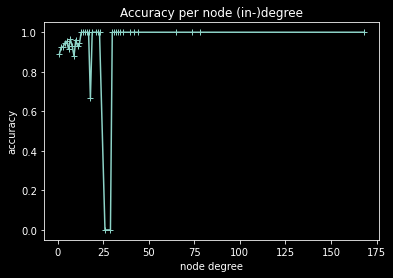

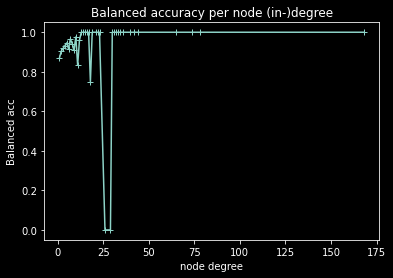

In [ ]:
from lib.util import plot

y_hat = model.predict(data)
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)
y_true = data.y.reshape(-1)

node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree

degrees = torch.unique(node_degree)

degrees_with_samples = []
accs = []
balanced_accs = []
for d in degrees:
  degree_mask = nd == d
  if y_hat[degree_mask].shape[0] > 0:
    acc, balanced_acc = get_multiclass_classification_performance(y_hat[degree_mask], y_true[degree_mask])

    degrees_with_samples.append(d)
    accs.append(acc)
    balanced_accs.append(balanced_acc)

plot("Accuracy per node (in-)degree", degrees_with_samples, accs, "node degree", "accuracy", save_file=True)
plot("Balanced accuracy per node (in-)degree", degrees_with_samples, balanced_accs, "node degree", "Balanced acc", save_file=True)

# Conformal prediction (standard)

In [ ]:
from lib.conformal_predictor import ConformalClassifier, get_nonconformity_measure_for_classification

cal_y_hat = model.predict(data)
cal_y_hat = cal_y_hat[calibration_indices]
y_true = data.y[calibration_indices]
cal_y_hat = cal_y_hat
y_true = y_true
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas, version="v2")
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

cp = ConformalClassifier(cal_alphas, cal_y)

## coverage and efficiency

In [ ]:
from lib.evaluation import get_coverage_and_efficiency

CONFIDENCE_LEVEL = 0.95

def get_confidence_intervals(cp, y_hat, confidence_level=0.95, mondrian_category=None):
  confidence_intervals = []
  for yi in y_hat:
    alphas = get_nonconformity_measure_for_classification(yi, version="v2")
    ci = cp.predict(alphas, confidence_level, mondrian_category)
    confidence_intervals.append(ci)
  
  return confidence_intervals

y_hat = model.predict(data)
y_true = data.y
# get test indices
y_hat = y_hat[test_indices]
y_true = y_true[test_indices]

### Overall

In [ ]:
from lib.util import print_percentage

confidence_intervals = get_confidence_intervals(cp, y_hat, CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

def print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred):
  print_percentage("Coverage", coverage)
  print("Avg prediction set size: {:.2f}".format(avg_prediction_set_size))
  print_percentage("Singleton predictions", frac_singleton_pred)
  print_percentage("Empty predictions", frac_empty_pred)

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

Confidence level: 95.00%
Coverage: 96.30%
Avg prediction set size: 1.72
Singleton predictions: 64.70%
Empty predictions: 0.00%


### Per class

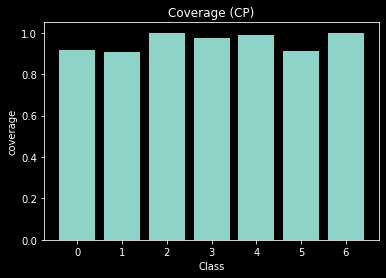

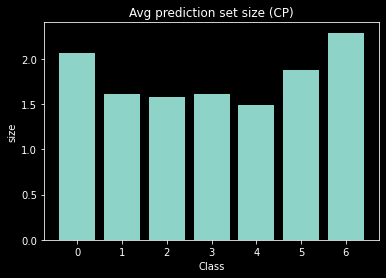

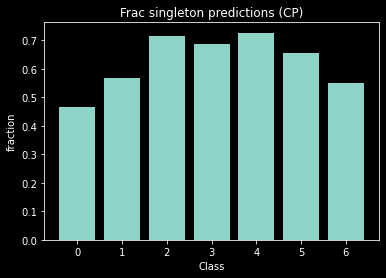

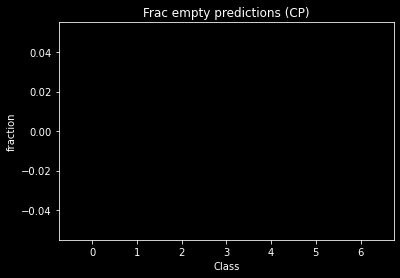

In [ ]:
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for c in range(dataset.num_classes):
  class_mask = y_true == c

  confidence_intervals = get_confidence_intervals(cp, y_hat[class_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_mask])

  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

def plot_bar(title, x, y, x_label, y_label, save_file=False):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.bar(x, y)
  if save_file:
    plt.savefig(title + ".png")
  plt.show()

save_plot = True
x_label = "Class"
classes = range(dataset.num_classes)
plot_bar("Coverage (CP)", classes, coverages, x_label, "coverage", save_plot)
plot_bar("Avg prediction set size (CP)", classes, avg_prediction_set_sizes, x_label, "size", save_plot)
plot_bar("Frac singleton predictions (CP)", classes, frac_singleton_preds, x_label, "fraction", save_plot)
plot_bar("Frac empty predictions (CP)", classes, frac_empty_preds, x_label, "fraction", save_plot)

### per node (in-)degree

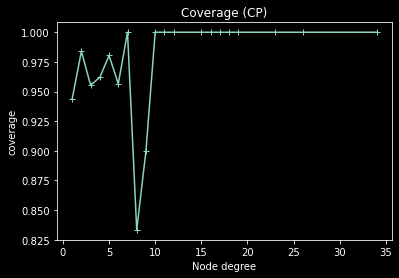

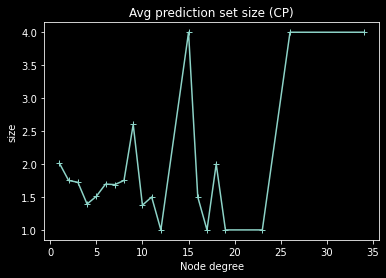

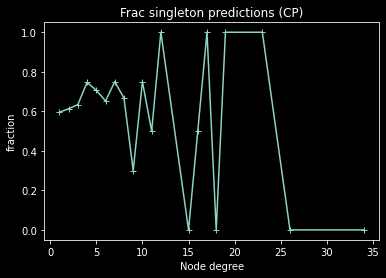

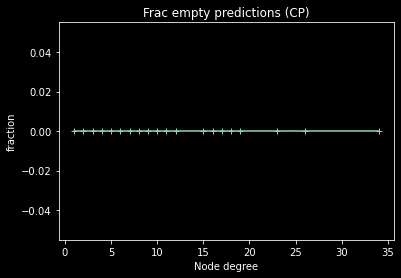

In [ ]:
node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree
# only keep test indices
nd = nd[test_indices]

degrees = torch.unique(nd)

degrees_with_samples = []
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for d in degrees:
  degree_mask = nd == d
  if y_true[degree_mask].shape[0] == 0:
    continue

  confidence_intervals = get_confidence_intervals(cp, y_hat[degree_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  degrees_with_samples.append(d)
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = True
x_label = "Node degree"
plot("Coverage (CP)", degrees_with_samples, coverages, x_label, "coverage", save_plot)
plot("Avg prediction set size (CP)", degrees_with_samples, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("Frac singleton predictions (CP)", degrees_with_samples, frac_singleton_preds, x_label, "fraction", save_plot)
plot("Frac empty predictions (CP)", degrees_with_samples, frac_empty_preds, x_label, "fraction", save_plot)

# Mondrian Conformal Prediction (MCP) (class-based)

In [ ]:
mcp_class = ConformalClassifier(cal_alphas, cal_y, True)

## Performance
### Overall

In [ ]:
confidence_intervals = get_confidence_intervals(mcp_class, y_hat, CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)


Confidence level: 95.00%
Coverage: 95.19%
Avg prediction set size: 1.91
Singleton predictions: 58.41%
Empty predictions: 0.00%


### Per class

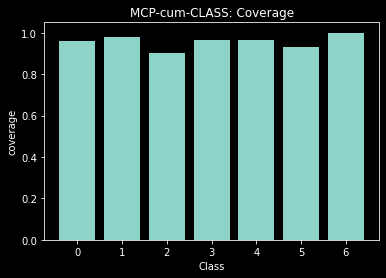

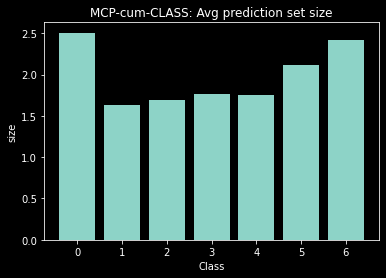

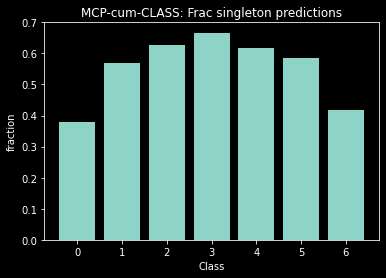

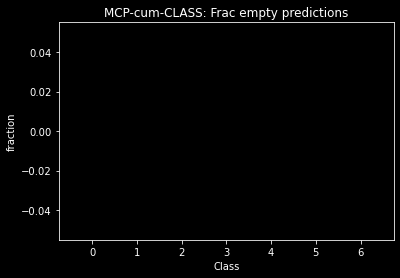

In [ ]:
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for c in range(dataset.num_classes):
  class_mask = y_true == c

  confidence_intervals = get_confidence_intervals(mcp_class, y_hat[class_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_mask])

  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = True
x_label = "Class"
classes = range(dataset.num_classes)
plot_bar("MCP-cum-CLASS: Coverage", classes, coverages, x_label, "coverage", save_plot)
plot_bar("MCP-cum-CLASS: Avg prediction set size", classes, avg_prediction_set_sizes, x_label, "size", save_plot)
plot_bar("MCP-cum-CLASS: Frac singleton predictions", classes, frac_singleton_preds, x_label, "fraction", save_plot)
plot_bar("MCP-cum-CLASS: Frac empty predictions", classes, frac_empty_preds, x_label, "fraction", save_plot)

### Per node (in-)degree

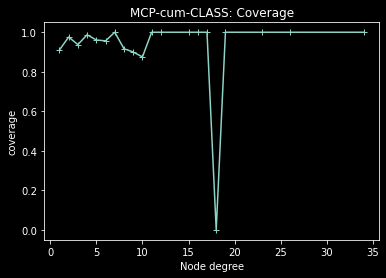

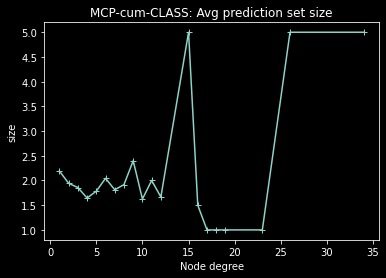

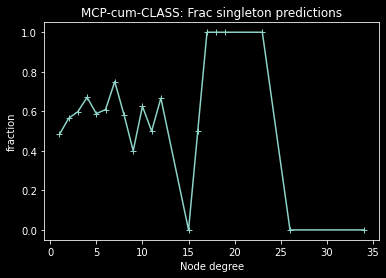

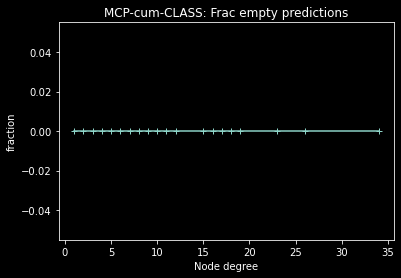

In [ ]:
degrees_with_samples = []
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for d in degrees:
  degree_mask = torch.logical_and(nd == d, y_true != -1)
  if y_true[degree_mask].shape[0] == 0:
    continue

  confidence_intervals = get_confidence_intervals(mcp_class, y_hat[degree_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  degrees_with_samples.append(d)
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = True
x_label = "Node degree"
plot("MCP-cum-CLASS: Coverage", degrees_with_samples, coverages, x_label, "coverage", save_plot)
plot("MCP-cum-CLASS: Avg prediction set size", degrees_with_samples, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("MCP-cum-CLASS: Frac singleton predictions", degrees_with_samples, frac_singleton_preds, x_label, "fraction", save_plot)
plot("MCP-cum-CLASS: Frac empty predictions", degrees_with_samples, frac_empty_preds, x_label, "fraction", save_plot)

# standard MCP (node (in-)degree based)

In [ ]:
BINS = torch.tensor([0,1,2]) # boundaries[i-1] < input[x] <= boundaries[i]

# get node degrees
c_node_ids, c_node_degrees = torch.unique(data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes


c_node_degrees_bins = torch.bucketize(cal_node_degrees, BINS)

calibration_taxonomy = c_node_degrees_bins

mcp_node_degree = ConformalClassifier(cal_alphas, cal_y, True, calibration_taxonomy, False)

## Performance

### Overall

Confidence level: 95.00%
Coverage: 95.56%
Avg prediction set size: 1.89
Singleton predictions: 54.90%
Empty predictions: 0.00%


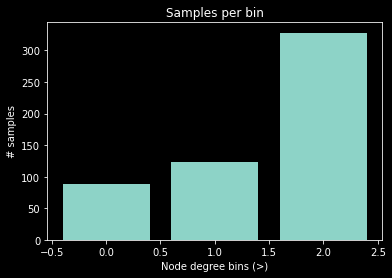

In [ ]:
nd_bins = torch.bucketize(nd, BINS)

degrees = torch.unique(nd_bins)

coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
samples_per_bin = []

for d in degrees:
  degree_mask = nd_bins == d
  
  confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_mask], CONFIDENCE_LEVEL, d)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  samples_per_bin.append(y_true[degree_mask].shape[0])
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

dataset_size = torch.sum(torch.tensor(samples_per_bin))
avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_bin) / dataset_size)
avg_prediction_set_size = torch.sum(torch.tensor(avg_prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size) 

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(avg_coverage, avg_prediction_set_size, avg_frac_singleton_pred, avg_frac_empty_pred)

plot_bar("Samples per bin", BINS, samples_per_bin, "Node degree bins (>)", "# samples", True)

### Performance per node degree bucket

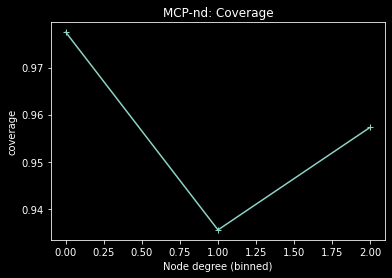

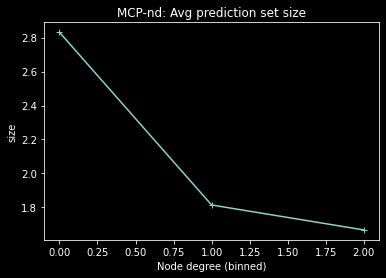

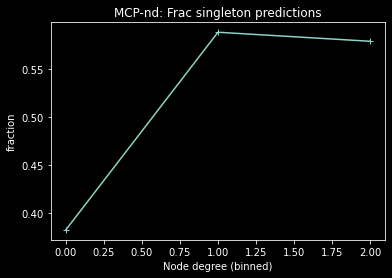

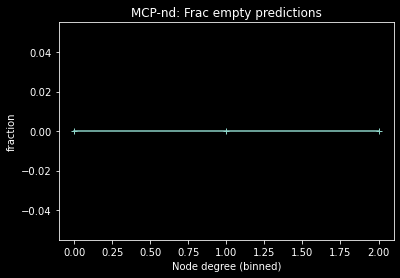

In [ ]:
save_plot = True
x_label = "Node degree (binned)"
plot("MCP-nd: Coverage", BINS, coverages, x_label, "coverage", save_plot)
plot("MCP-nd: Avg prediction set size", BINS, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("MCP-nd: Frac singleton predictions", BINS, frac_singleton_preds, x_label, "fraction", save_plot)
plot("MCP-nd: Frac empty predictions", BINS, frac_empty_preds, x_label, "fraction", save_plot)

### Performance per class

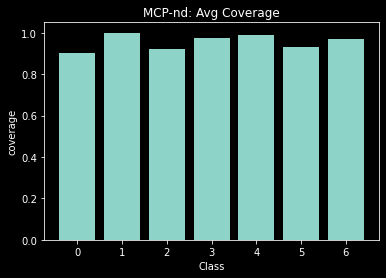

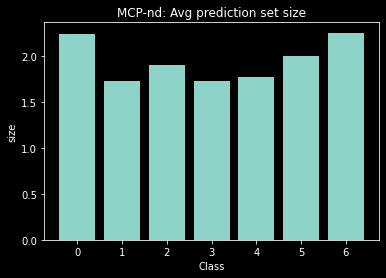

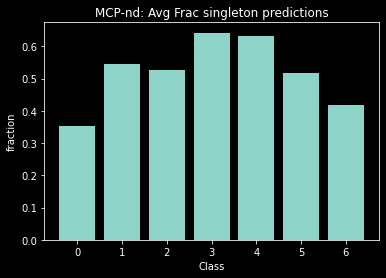

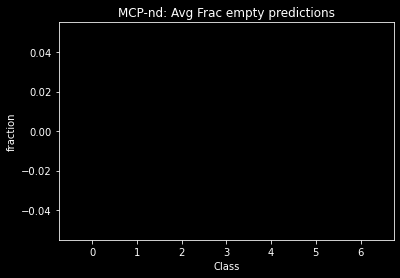

In [ ]:
avg_coverages = []
avg_prediction_set_sizes = []
avg_frac_singleton_preds = []
avg_frac_empty_preds = []
for c in range(dataset.num_classes):
  coverages = []
  prediction_set_sizes = []
  frac_singleton_preds = []
  frac_empty_preds = []
  samples_per_bin = []
  for d in degrees:
    degree_class_mask = torch.logical_and(nd_bins == d, y_true == c)

    confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_class_mask], CONFIDENCE_LEVEL, d)
    
    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_class_mask])

    samples_per_bin.append(y_true[degree_class_mask].shape[0])
    coverages.append(coverage)
    prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  dataset_size = torch.sum(torch.tensor(samples_per_bin))
  avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_bin) / dataset_size)
  avg_prediction_set_size = torch.sum(torch.tensor(prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size)
  avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size)
  avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size)
  
  avg_coverages.append(avg_coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  avg_frac_singleton_preds.append(avg_frac_singleton_pred)
  avg_frac_empty_preds.append(avg_frac_empty_pred)

save_plot = True
x_label = "Class"
classes = range(dataset.num_classes)
plot_bar("MCP-nd: Avg Coverage", classes, avg_coverages, x_label, "coverage", save_plot)
plot_bar("MCP-nd: Avg prediction set size", classes, avg_prediction_set_sizes, x_label, "size", save_plot)
plot_bar("MCP-nd: Avg Frac singleton predictions", classes, avg_frac_singleton_preds, x_label, "fraction", save_plot)
plot_bar("MCP-nd: Avg Frac empty predictions", classes, avg_frac_empty_preds, x_label, "fraction", save_plot)

# Cumulative MCP (node (in-)degree based)

In [ ]:
BINS = torch.tensor([0,1,2,3,4,5,6,7,8,9,10]) # boundaries[i-1] < input[x] <= boundaries[i]

# get node degrees
c_node_ids, c_node_degrees = torch.unique(data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes


c_node_degrees_bins = torch.bucketize(cal_node_degrees, BINS)

calibration_taxonomy = c_node_degrees_bins

mcp_node_degree = ConformalClassifier(cal_alphas, cal_y, True, calibration_taxonomy, True)

## Performance

### Overall

Confidence level: 95.00%
Coverage: 95.36%
Avg prediction set size: 1.96
Singleton predictions: 57.18%
Empty predictions: 0.00%


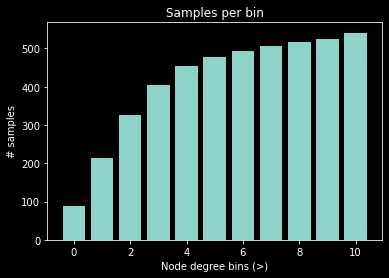

In [ ]:
nd_bins = torch.bucketize(nd, BINS)

degrees = torch.unique(nd_bins)

coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
samples_per_bin = []

for d in degrees:
  degree_mask = nd_bins <= d
  
  confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_mask], CONFIDENCE_LEVEL, d)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  samples_per_bin.append(y_true[degree_mask].shape[0])
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

dataset_size = torch.sum(torch.tensor(samples_per_bin))
avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_bin) / dataset_size)
avg_prediction_set_size = torch.sum(torch.tensor(avg_prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size) 

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(avg_coverage, avg_prediction_set_size, avg_frac_singleton_pred, avg_frac_empty_pred)

plot_bar("Samples per bin", BINS, samples_per_bin, "Node degree bins (>)", "# samples", True)

### Performance per node degree bucket

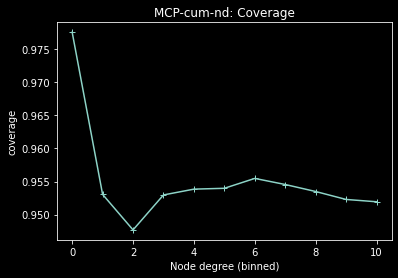

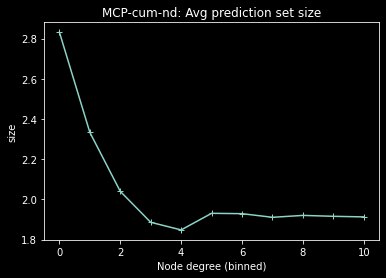

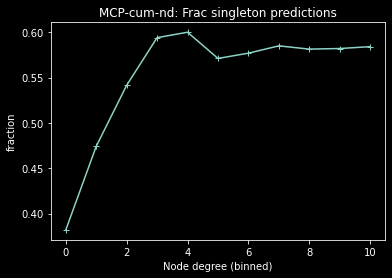

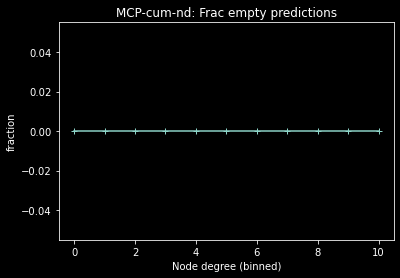

In [ ]:
save_plot = True
x_label = "Node degree (binned)"
plot("MCP-cum-nd: Coverage", BINS, coverages, x_label, "coverage", save_plot)
plot("MCP-cum-nd: Avg prediction set size", BINS, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("MCP-cum-nd: Frac singleton predictions", BINS, frac_singleton_preds, x_label, "fraction", save_plot)
plot("MCP-cum-nd: Frac empty predictions", BINS, frac_empty_preds, x_label, "fraction", save_plot)

# Cumulative MCP (class-based)

In [ ]:
mcp_class_cum = ConformalClassifier(cal_alphas, cal_y, True, cal_y, True)

In [ ]:
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
samples_per_class = []
for c in range(dataset.num_classes):
  class_mask = y_true <= c

  confidence_intervals = get_confidence_intervals(mcp_class_cum, y_hat[class_mask], CONFIDENCE_LEVEL, c)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_mask])

  samples_per_class.append(y_true[class_mask].shape[0])
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

dataset_size = torch.sum(torch.tensor(samples_per_class))
avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_class) / dataset_size)
avg_prediction_set_size = torch.sum(torch.tensor(avg_prediction_set_sizes) * torch.tensor(samples_per_class) / dataset_size) 
avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_class) / dataset_size) 
avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_class) / dataset_size) 

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(avg_coverage, avg_prediction_set_size, avg_frac_singleton_pred, avg_frac_empty_pred)


Confidence level: 95.00%
Coverage: 95.01%
Avg prediction set size: 1.62
Singleton predictions: 61.82%
Empty predictions: 0.57%


# Weighted Conformal Prediction

Inspired by "Conformal prediction beyond exchangeability" (2022)

In [ ]:
class DegreeWeightedConformalClassifier():
  """
  Inductive conformal prediction based on "Tutorial On Conformal Prediction" by Shafer & Vovk (p. 388).
  Extended with Mondrian Conformal Prediction option based on "Mondrian Conformal Regressors" by Boström & Johansson, and https://gist.github.com/dsleo/2880882b5e1c1feab677c4cf421e806d
  """
  def __init__(self, alphas, y, degrees):
    """
    alphas: non-conformity measures (n_samples).
    y: targets (n_samples)
    mondrian_taxonomy: the samples categories (n_samples)
    """
    super()

    self.alphas = alphas
    self.y = y
    self.degrees = degrees

    return
  
  def predict(self, alphas, degree, confidence_level):
    """
    Retrieve a prediction region for the provided nonconformity measures 
    \nOBS! Only single samples allowed
    \nconfidence_level: e.g. 0.99
    """

    significance_level = 1 - confidence_level

    prediction_region = []

    classes = torch.unique(self.y)
    
    # weights
    max_degree = torch.max(torch.cat((self.degrees, torch.tensor([degree]))))
    normalized_degrees = self.degrees / max_degree
    weights = 1 - torch.abs((degree/max_degree) - normalized_degrees)
    sum_weights = torch.sum(weights) + 1
    normalized_weights = weights / sum_weights
    normalized_weight = 1 / sum_weights

    for y in classes:
      ai = alphas[y] * normalized_weight

      # non-conformity scores
      a = self.alphas * normalized_weights
      
      # calculate p-score
      c = torch.count_nonzero(a >= ai)
      p_score = c / len(a)

      if p_score > significance_level:
        prediction_region.append(y)
    # END: for
      
    return prediction_region

In [ ]:
node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree
# only keep test indices
cal_nd = nd[calibration_indices]

cp = DegreeWeightedConformalClassifier(cal_alphas, cal_y, cal_nd)

def get_confidence_intervals_weighted(cp, y_hat, degrees, confidence_level=0.95):
  confidence_intervals = []
  for yi, d in zip(y_hat,degrees):
    alphas = get_nonconformity_measure_for_classification(yi, version="v2")
    ci = cp.predict(alphas, d, confidence_level)
    confidence_intervals.append(ci)
  
  return confidence_intervals

test_nd = nd[test_indices]
confidence_intervals = get_confidence_intervals_weighted(cp, y_hat, test_nd, CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

Confidence level: 95.00%
Coverage: 93.53%
Avg prediction set size: 1.35
Singleton predictions: 77.45%
Empty predictions: 0.00%
